<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 12 – Neural Networks II
 
### Objectives:

- Develop an understanding of Recrrent Neural Networks (RNN)
- Implement LSTM, which is a special type of RNN architecture
- Note: the tutorial 12 materials are desinged in a way to potentialy faciliate your group assignment works, in case you want to utilize the RNN (in particular LSTM) techniques in the group assignment works. The technical details of the RNN (including LSTM) will be further explained in Lecture 12 and the tutorial 12 focuses on the practical implementation of LSTM.

In this tutorial, we will keep working on the example with the **AirPassengers** dataset of the last tutorial but using the recurrent neural network to make forecasts. The step 1-3 will be repeated for the data pre-processing and tran/test split tasks.

## 1. Import required libraries/functions and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Library for neural networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential

Load the Airpassenger data from a csv file

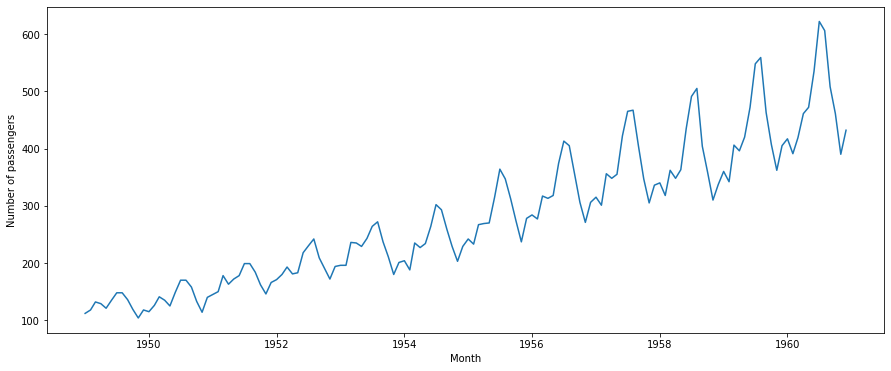

In [2]:
data_raw = pd.read_csv('AirPassengers.csv')
data_raw['Month'] = pd.to_datetime(data_raw['Month']) # Convert the data in the Month column to datetime
data_raw.set_index('Month', inplace=True)             # Indexing the DataFrame by the Month column

# Convert data from Dataframe to array
# We name the new data as data_not_scaled as we will scale the data later on
data_not_scaled = data_raw.dropna()               # Drop all Nans
data_not_scaled = data_not_scaled.values          # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float') # You need to make sure the data is type of float

# Plot the time series
plt.figure(figsize=(15,6))
plt.plot(data_raw.index,data_not_scaled)
plt.xlabel('Month')
plt.ylabel('Number of passengers')
plt.show()

## 2. Data pre-processing and train/test split

We re-use the same code shown in Tutorial 11 to pre-process (scaling) the data and perform train/test split. First, let's scale the time series to the range $[0,1]$ using only training data to construct the parameters for the scaler. In this example, the `time_window` is equal to the seasonal period. However, we can also consider `time_window` as a hyper-parameter and perform grid-search for it to improve the performance of trained NN.  

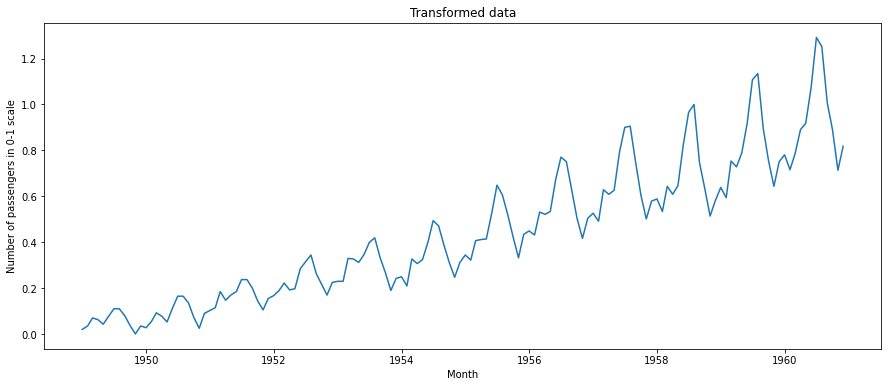

In [3]:
# Time window to define the number of features in each row
time_window = 12

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
train_size = int((len(data_not_scaled)-time_window) * 0.8)
test_size = len(data_not_scaled) - train_size-time_window

# Fitting the scaler
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(data_not_scaled)

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(data_raw.index,data_scaled)
plt.xlabel('Month')
plt.ylabel('Number of passengers in 0-1 scale')
plt.title('Transformed data')
plt.show()

We then reconstruct the data in tabular format and split the new data to train and test parts. It's important to note that this data reconstruction step is important when we want to use Feedforward Neural Network (NN) to model the time series data (why?). The Recurrent Neural Networks (RNNs), however, are designed to capture the time dependency exhibited within the time series data, so this data reconstruction step is not that important, implying that you can set `time_window=1` as still be able to obtain reasonale results, compared to the case of `time_window>1`. In this example, we keep using  `time_window=12` to directly compare the performance of NN and RNN models. You are encouraged to try `time_window=1` to see the difference. 

In [4]:
# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0])
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0])
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

## 4. Recurrent NN and LSTM (Long-Short Term Memory)

There are several standard time series models. One approach is to represent time effects explicitly via some simple functions, often a linear function, of the lagged values of the time series. This is the mainstream time series data analysis approach with the well-known ARIMA methods (or Box-Jenkin methods). In lecture 12, we considered an alternative approach representing time effects implicitly via latent variables that are designed to store the memory of the dynamics in the data. These latent variables, also called *hidden states*, are updated recurrently using the information carried over by their values from the past and the information from the data at the current time.

Let's the time series data be $\{D_t=(x_t,y_t),t=1,2,...\}$ where $x_t$ is the vector of inputs and $y_t$ the output. For the univariate time series, it is useful to think of $x_t$ is the array of lagged values of $y_t$.  If the serial dependence structure is ignored, then a feedforward neural network (FNN or NN) can be used to transform the raw input data $x_t$ into a set of hidden units $h_t$, often called learned features, for the purpose of explaining or predicting the output $y_t$. The figure below is a graphical representation of a FNN model with one hidden layer containing L hidden units

<div style="margin-bottom: 0px;"><img width=500 src="FNN.jpg"> </div>

FNN provide a powerful way to approximate the true function that maps the input $x_t$ to the mean $\mathbb{E}(y_t|x_t)$ or to transform the raw data $x_t$ into summary statistics $h_t$ having some desirable properties. However, when FNN is used for time series data analysis, the time effects and the serial correlations are ignored. The main idea behind RNNs is to let the set of hidden units $h_t$ feed itself on its lagged value $h_{t-1}$. Hence, a RNN can be best thought of as a FNN that allows a connection of the hidden units to their value from the previous time step, enabling the network to possess memory. The figure below intuitively explains the difference between FNN and RNN.

<div style="margin-bottom: 0px;"><img width=800 src="RNN.jpg"> </div>

It is important to note that RNN is a general term, not a specific model. It depends on how hidden states are constructed then we can defined specific variants of RNN. For example the most basic RNN model is called Elman RNN, or Simple RNN, using a very simple structure to describe the movement of hidden states over time

$$
\begin{aligned}
h_t &= \phi(U x_t + W h_{t-1} + b) \\
\eta_t &= \beta_0 + \beta_1 h_t \\
y_t &= \eta_t + \varepsilon_t 
\end{aligned}
\tag{1}
$$

Here $\phi(\cdot)$ is an activation function. Using the unfold graph of general RNN and the model in (1), we can plot the graphicall represesentation of the Simple RNN model as shown in the figure below. The simple RNN model is a sequence of SRN unit whose mathematical equation is described in (1).

<div style="margin-bottom: 0px;"><img width=600 src="SRN.jpg"> </div>

Another important variant of RNN is Long-short term memory (LSTM). The main idea of the LSTM is to use LSTM cells within a recurrent neuron network to capture the long term dependence and nonlinear effects that could be exhibited in the time series. Students are encouraged to revise the lecture 12 for more details about LSTM. Fortunately, using Keras, changing our neural network to use a LSTM layer is relatively straight forward.

Keras requires the data input  of RNN models have to be reshaped to 3D array representing `[sample,timestep,feature]`. Currently, our data `Xtrain,Xtest` are in the form `[samples, features]`, where `samples` is the number of rows and `features=1` for uni-variate time series. `timestep` is the number of time steps in each number, which is defined by the `time_window` variable. Finally, we will reshape the input data to the shape `[sample,time_window,1]`.

In [5]:
# For time series and LSTM layer we need to reshape into 3D array 
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window,1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window,1))

We then define a LSTM model with one hidden layer of 8 LSTM cells. The `input_shape` argument is set to be `input_shape=(time_window,1)` to represent `[timestep,feature]`.  Let's define a LSTM model including one hidden layer with $8$ LSTM blocks or neurons.

In [6]:
model = Sequential()
model.add(LSTM(units=8,input_shape = (time_window,1))) 
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


**Notes:**

Here, we are using `adam` optimizer which is a common choice to train LSTM models. Tuning is much more difficult with LSTM since we now have more interacting parameters and a more complex network. Sometimes tuning for your data can take a lot of time. It is part of the skill of using neural networks. Please familiarize yourself with the terminology and how each parameter affects fitting result.

- **Units** is the dimension of the weight vector inside the LSTM “neurons” or cells. Increasing this number can lead to overfitting, decreasing can lead to poor accuracy. You need to make a tradeoff.
- **Batch size** is the number of samples used in each forward/backward pass of the network. You will notice the number of samples in each Epoch increasing by the batch size. It is suggested that for time series forecasting decreasing the batch size you may get more divergent results (less accuracy) but each Epoch completes quicker.
- An **Epoch** is a forward/backward pass of all batches. If you increase the Epoch you should see an improvement in accuracy since it is refining the model parameters each time.
- The **validation split** is the proportion of data held out for use as validation set. As it decreases training accuracy will increase since more training data is available, but the guarantee of generalization is much lower. For small amounts of data and for small epoch it is better to keep this number small.
- **Shuffle** will decide whether to shuffle the training data before each epoch

## 5. Train the model with Early Stopping

Early stopping is a technique to prevent over-training when a monitored quantity has stopped improving.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

Here, monitor is the quantity to be monitored. `patience` is the number of epochs with no improvement after which training will be stopped. Here, we are monitoring validation loss. If you are interested with further parameter settings in this function, you can refer to https://keras.io/callbacks/#earlystopping

Then, we train the model by calling the `.fit()` function

In [8]:
model.fit(Xtrain, Ytrain, 
          batch_size = 5,             
          epochs = 300,               
          validation_split = 0.1, 
          shuffle = False,
          verbose = 1, 
          callbacks = [early_stop])

Epoch 1/300
19/19 [==============================] - 2s 34ms/step - loss: 0.1096 - val_loss: 0.2704
Epoch 2/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.1037
Epoch 3/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0539
Epoch 4/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0228 - val_loss: 0.0479
Epoch 5/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0208 - val_loss: 0.0461
Epoch 6/300
19/19 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0415
Epoch 7/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0369
Epoch 8/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0336
Epoch 9/300
19/19 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0310
Epoch 10/300
19/19 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0291
Epoch 11

Given the trained NN model, it's straighforward to make one-step-ahead forecast, e.g. $\widehat{Y}_{t+1|1:t}$, using the `predict()` method of the `Sequential()` class. The `predict` method also requires the input data have to be reshaped to 3D array. 

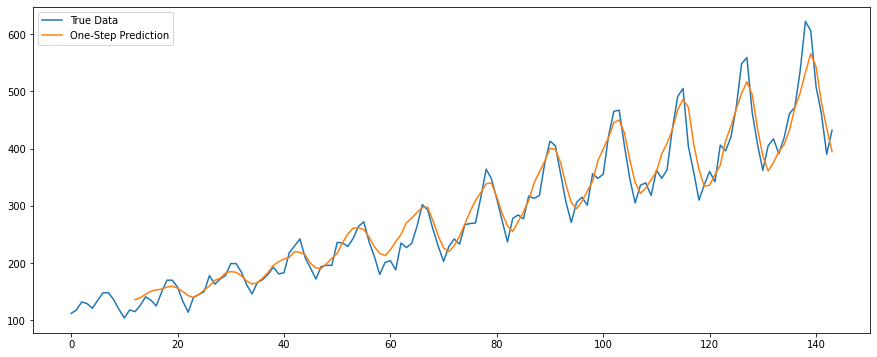

Training Data RMSE: 0.05
Test Data RMSE: 0.09


In [9]:
# Predicting
allPredict = model.predict(np.reshape(Xall, (Xall.shape[0],time_window,1)))

#Transforming to original scale
allPredict_original_scale = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data_scaled)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict_original_scale

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction')
plt.legend()
plt.show()

# Checking training and test score
trainScore = np.sqrt(mean_squared_error(Ytrain, allPredict[:train_size,0]))
testScore = np.sqrt(mean_squared_error(Ytest, allPredict[-test_size:,0]))

print('Training Data RMSE: {0:.2f}'.format(trainScore))
print('Test Data RMSE: {0:.2f}'.format(testScore))

## 6. Dynamic forecast with LSTM

Finally, we also applied the dynamic forecast with LSTM. In real world, we do not have access to the future values, so we have to do so called dynamic forecast for multi-step-ahead forecast. This forecast uses observations up to some time point. From that point onwards we append our latest forecast to the list and use a combination of real values and estimated values as input features. Eventually if the forecast length exceeds the window of values used, we will be only using forecast values.

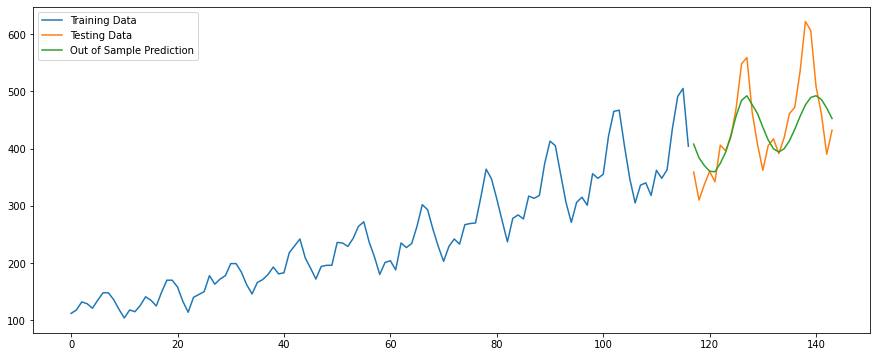

Dynamic Forecast RMSE: 0.14


In [10]:
#Dynamical Prediction
dynamic_prediction = np.copy(data_scaled[:len(data_scaled) - test_size])

for i in range(len(data_scaled) - test_size, len(data_scaled)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# Transform forecast values to original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

# Plot
test_index = np.arange(len(data_scaled) - test_size, len(data_scaled), 1)

plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled[:len(data_scaled) - test_size]), label='Training Data')
plt.plot(test_index, scaler.inverse_transform(data_scaled[-test_size:]), label='Testing Data')
plt.plot(test_index, dynamic_prediction_original_scale[-test_size:], label='Out of Sample Prediction') 
plt.legend(loc = "upper left")
plt.show()

# Compute RMSE score on test data
testScore = np.sqrt(mean_squared_error(Ytest, dynamic_prediction[-test_size:]))
print('Dynamic Forecast RMSE: {0:.2f}'.format(testScore))
